__Goal__: Test Combined Modelling

  We want to test the CombinedModel class, which receives Pyautolens Model and Jam Model and perform the non linear search.
This is the class used in the MCMC. 

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

import CombinedModel
from My_Jampy import JAM

data_folder = "/home/carlos/Documents/GitHub/Master-Degree/Autolens tests/autolens_workspace/Test_4/Simulation_Data/"

In [2]:
#Reading inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)      #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)           #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True) #PSF
x, y, vrms, erms              = np.loadtxt("Input/vrms_data.txt", unpack=True)      #vrms data

### Input parameters
Defining same inputs used for Jampy simulation (you can find it in __input_parameters.txt__, inside Simulation Data folder). And the necessary inputs for Autolens. 

In [3]:
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 4.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 0.075                                                         #kappa_s of DM profile
r_s    = 11.5
ml     = 7.00                                                          #mass to light ratio
phi_shear = 88                                                         #Inclination of external shear [deg]
mag_shear = 0.02                                                       #magnitude of shear
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=mag_shear, phi=phi_shear) #external shear

beta    = np.full_like(surf_lum, -0.15)                                 #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                    (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio
pixsize = 0.2                                                           #MUSE pixel size

### Reading Image

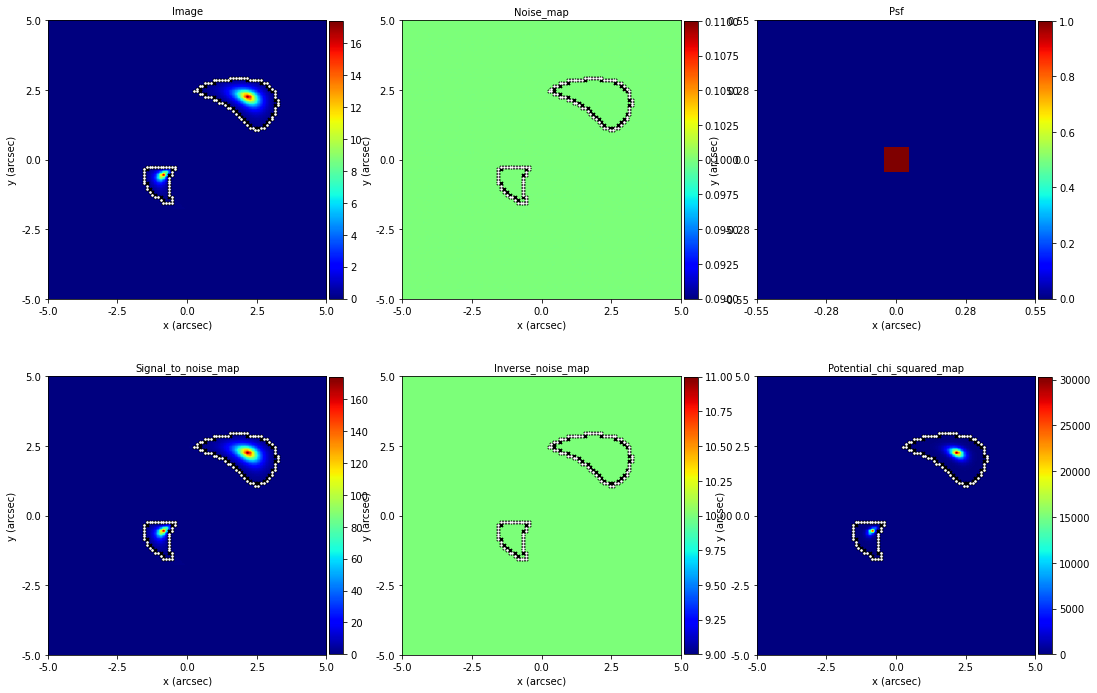

In [4]:
imaging = al.Imaging.from_fits(
        image_path=f"{data_folder}/arcs_simulation.fits",
        noise_map_path=f"{data_folder}/noise_simulation.fits",
        psf_path=f"{data_folder}/psf_simulation.fits",
        pixel_scales=0.1,
    )

mask        = al.Mask.from_fits( file_path=f"{data_folder}/new_mask.fits", hdu=1, 
                                    pixel_scales=imaging.pixel_scales)#You should check Mask_Maker folder before continue

masked_image = al.MaskedImaging(imaging=imaging, mask=mask, inversion_uses_border=True)     #Masked image


aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True),                         #Plot
)

## Jampy Model

In [5]:
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)

#Add DM component
Jam_model.DM_component(surf_dm=kappa_ * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

### Autolens Model

In [6]:
 #Elliptical components in Pyautolens units
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units
eNFW      = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_, elliptical_comps=ell_comps, scale_radius=r_s) #pseudo elliptical NFW

mass_profile = al.mp.MGE()                            #MGE mass model
mass_profile.Analytic_Model(analytic_profile=eNFW)   #Include the analytical pENFW

#Components
mass_profile.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh) #DON'T INCLUDE THE MGE PARAMETRIZATION OF DM

#Grid
#mass_profile.MGE_Grid_parameters(masked_image.grid)

#Lens galaxy
lens_galaxy = al.Galaxy(
    redshift=z_l,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

## Initializing Combined Model
__Scalar Beta and Scalar ML__

In [7]:
#Starting Model
model_MGE = CombinedModel.Models(Jampy_model=Jam_model, mass_profile=mass_profile,
                                 masked_imaging=masked_image, quiet=False)


Change qinc limits to [0.0501, 0.55], defaults are [0.0, 1]


In [8]:
#Setup Configurations

model_MGE.mass_to_light(ml_kind='scalar')                                          #Setting scalar ML
model_MGE.beta(beta_kind='scalar')                                                 #Seting vector anisotropy
model_MGE.has_MGE_DM(a=True, filename="Input/eNFW.txt", include_MGE_DM="Dynamical")#Setting Dark matter component
model_MGE.include_DM_analytical(analytical_DM=eNFW)                                #Analytical eNFW

ParsDic {'ml': 7.0, 'beta': -0.15, 'qinc': 0.38837304829549607, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.813731905546916, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 1.0}
jam_axi_rms elapsed time sec: 0.64
inc=65.0 beta_z=-0.15 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 3.854e+13
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108115)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: 169.12873738428277
Log Normalization -1317.2315249194833
Log Evidence: -640.3839755037264
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 1.0
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108115)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_

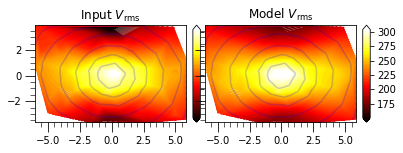

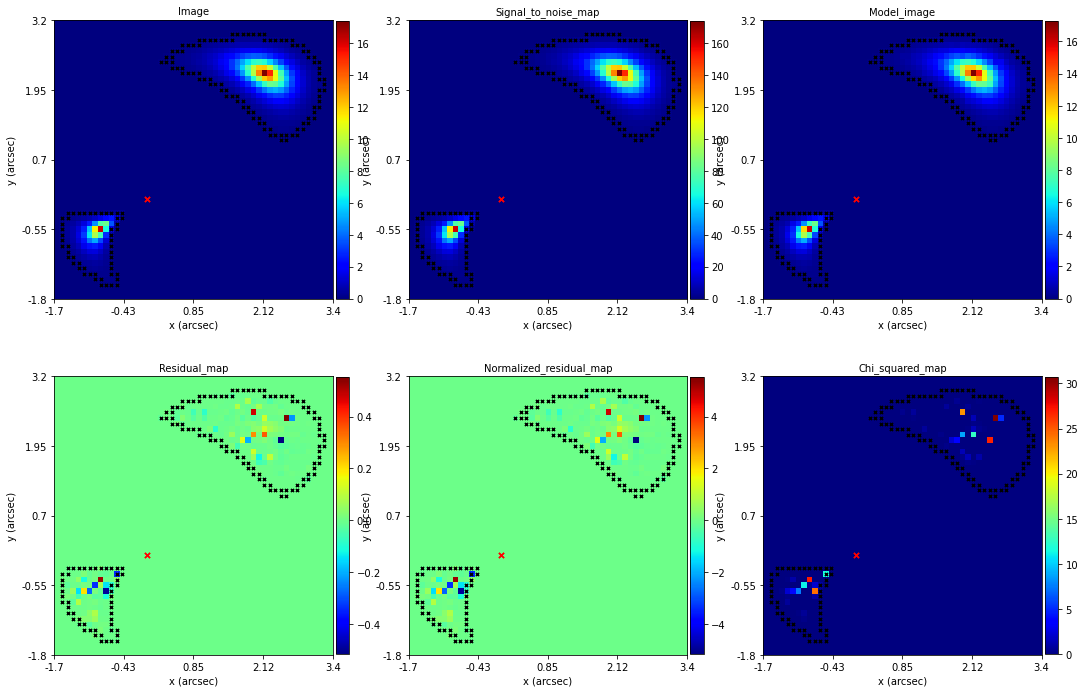

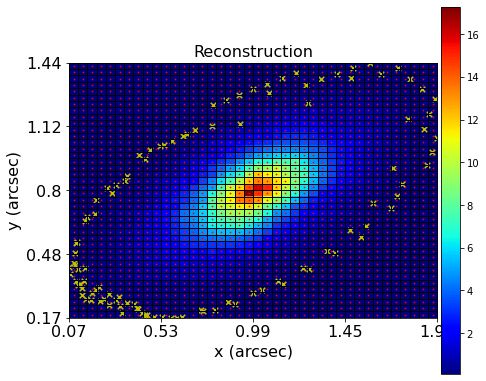

CPU times: user 8.09 s, sys: 155 ms, total: 8.25 s
Wall time: 7.08 s


119.12874881920143

In [9]:
#In order: ML, beta, qinc, log_mbh, kappa_s, qDM, mag_shear, phi_shear, gamma 
p0 = np.array([ml, beta[0], qinc, np.log10(mbh), kappa_, qDM, mag_shear, phi_shear, 1.00])

%time model_MGE(p0) 

ParsDic {'ml': 7.0, 'beta': -0.15, 'qinc': 0.38837304829549607, 'log_mbh': 9.0, 'kappa_s': 0.075, 'qDM': 0.813731905546916, 'mag_shear': 0.02, 'phi_shear': 88.0, 'gamma': 0.97}
jam_axi_rms elapsed time sec: 0.67
inc=65.0 beta_z=-0.15 M/L=1 BH=1.00e+09 chi2/DOF=1
Total mass MGE: 3.854e+13
Including the following Analytical DM profile:
#------------------------------------#
EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108115)
axis_ratio: 0.8499999999999999
phi: 0.0
kappa_s: 0.075
scale_radius: 11.5
inner_slope: 1.0


Lens Galaxy Configuration:
Log Likelihood_with_regularization: -100.4395340930306
Log Normalization -1317.2315249194833
Log Evidence: -912.9581399328803
#------------------------------------#
Redshift: 0.299
Mass Profiles:
MGE
centre: (0.0, 0.0)
epsabs: 1e-10
epsrel: 1e-05
processes: 1
method: quadva
gamma: 0.97
analytic_profile: EllipticalNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.08108108108108115)
axis_ratio: 0.8499999999999999
phi: 0.0
kapp

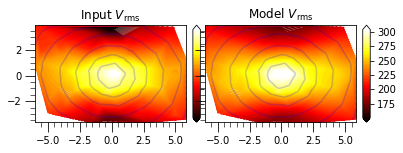

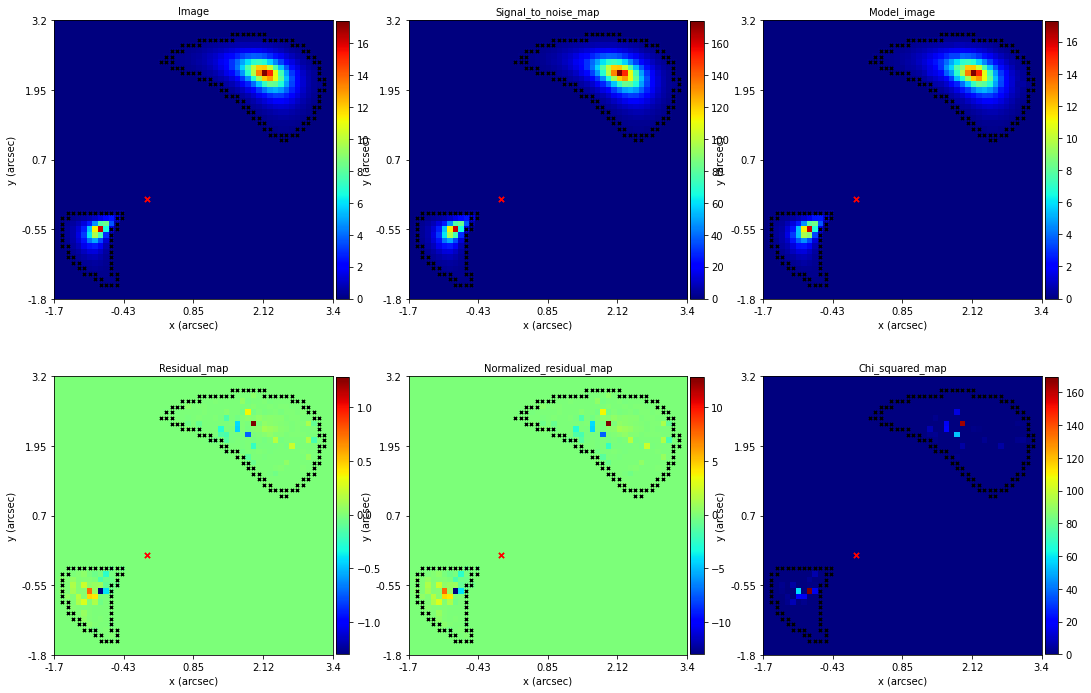

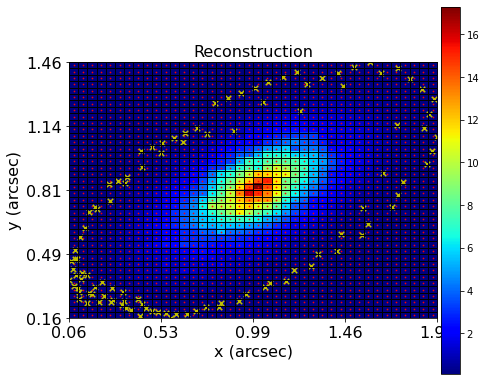

CPU times: user 4.73 s, sys: 87.8 ms, total: 4.82 s
Wall time: 3.73 s


-150.61952265811195

In [33]:
p0 = np.array([ml, beta[0], qinc, np.log10(mbh), kappa_, qDM, mag_shear, phi_shear, 0.97])

%time model_MGE(p0) 